# Neural Networks for Data Science Applications
## Lab session (extra): Robustness and interpretability

**Contents of the lab session:**
+ Evaluating adversarial attacks on a trained network.
+ Explaining the model with tf-explain or LIME.

In [1]:
# We are making use of the GPU here, so remember to enable it on Colab by:
# Runtime >> Change runtime type >> Hardware accelerator (before starting the VM).
!pip install -q tensorflow-gpu==2.0.0

     |████████████████████████████████| 380.8MB 47kB/s 
     |████████████████████████████████| 450kB 65.3MB/s 
     |████████████████████████████████| 3.8MB 64.5MB/s 
     |████████████████████████████████| 81kB 14.1MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.1 which is incompatible.


In [2]:
# We will use TF Datasets for the dataset
!pip install --upgrade tensorflow_datasets 

Requirement already up-to-date: tensorflow_datasets in /usr/local/lib/python3.6/dist-packages (1.3.0)


In [0]:
import tensorflow as tf
import numpy as np

### Preliminary: train a CNN on a benchmark dataset

In [0]:
import tensorflow_datasets as tfds

In [5]:
# Eurosat is a dataset of terrain classification from satellite measurements
dataset = tfds.load(name="eurosat", split=tfds.Split.TRAIN, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/eurosat/rgb/2.0.0.incompleteUQZYVU/eurosat-train.tfrecord


Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


(64, 64, 3)
tf.Tensor(4, shape=(), dtype=int64)


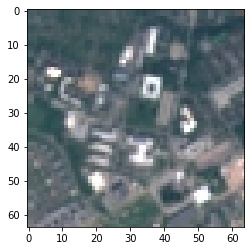

In [6]:
import matplotlib.pyplot as plt
for xb, yb in dataset.take(1):
  print(xb.shape)
  plt.imshow(xb)
  print(yb)

In [0]:
# Standard preprocessing (pixel scaling + one-hot encoding on the labels)
def preprocess_image(im, label):
  im = tf.cast(im, tf.float32) / 255.0
  label = tf.one_hot(label, 10)
  return im, label

In [0]:
dataset = dataset.map(preprocess_image)

In [0]:
test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)

In [0]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Input

In [0]:
def build_network():
  im = Input(shape=(64, 64, 3))

  x = Conv2D(64, 3, padding='same', activation='relu')(im)
  x = Conv2D(64, 3, padding='same', activation='relu')(x)
  x = MaxPooling2D(2)(x)

  x = Conv2D(64, 3, padding='same', activation='relu')(x)
  x = Conv2D(64, 3, padding='same', activation='relu')(x)
  x = MaxPooling2D(2)(x)

  x = Flatten()(x)

  x = Dropout(0.4)(x)
  x = Dense(10, activation='softmax')(x)
  return Model(inputs=[im], outputs=[x])

In [0]:
net = build_network()

In [0]:
from tensorflow.keras import losses, metrics, optimizers

In [0]:
loss = losses.CategoricalCrossentropy()
opt = optimizers.Adam(0.001)

In [0]:
net.compile(loss=loss, optimizer=opt, metrics=[metrics.BinaryAccuracy()])
net.fit(train_dataset.shuffle(1000).batch(32), epochs=3)

In [21]:
for xb, yb in test_dataset.batch(1):
  print(np.argmax(yb, axis=1))
  print(net.predict(xb))
  print(tf.argmax(net.predict(xb), axis=1))
  break

[4]
[[2.0800373e-13 5.3180857e-22 6.3897234e-05 2.4762763e-05 9.9982941e-01
  2.8306911e-11 1.6020052e-06 7.1843242e-05 8.4359590e-06 1.0046079e-16]]
tf.Tensor([4], shape=(1,), dtype=int64)


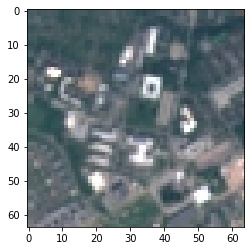

In [22]:
plt.imshow(xb[0])

### Testing adversarial robustness

In [24]:
# We use the IBM Adversarial Robustness 360 Toolbox
!pip install adversarial-robustness-toolbox

     |████████████████████████████████| 378kB 37.7MB/s 


In [0]:
from art.classifiers import TensorFlowV2Classifier
from art.attacks import FastGradientMethod

In [0]:
# First, we need to wrap the classifier in a TensorFlowV2Classifier object
# It allows the toolbox to compute the gradients of the model in a framework-agnostic way
classifier = TensorFlowV2Classifier(model=net, nb_classes=10, loss_object=losses.SparseCategoricalCrossentropy(), clip_values=(0, 1))

In [0]:
# We use a fast gradient sign attack
attack_fgsm = FastGradientMethod(classifier=classifier, eps=0.05, eps_step=0.01)

In [0]:
# Do the attack on the previous image
x_test_adv = attack_fgsm.generate(xb.numpy())

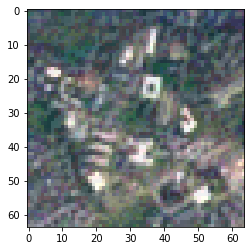

In [32]:
plt.imshow(x_test_adv[0])

In [33]:
for xb, yb in test_dataset.batch(1):
  print(yb)
  print(net.predict(x_test_adv))
  print(tf.argmax(net.predict(x_test_adv), axis=1))
  break

tf.Tensor([[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]], shape=(1, 10), dtype=float32)
[[1.03961595e-16 3.49431994e-17 6.08167786e-04 3.34765464e-05
  1.65585720e-03 2.46636080e-11 3.20278275e-07 9.97701585e-01
  6.17172361e-07 1.06402567e-17]]
tf.Tensor([7], shape=(1,), dtype=int64)


In [0]:
# Check out the other examples!
# https://github.com/IBM/adversarial-robustness-toolbox/blob/master/examples/README.md

### Interpreting the model while training

In [43]:
# We use the tf-explain library
!pip install tf-explain

In [0]:
from tf_explain import callbacks

In [0]:
# Get a small batch of images for the visualizations during training
Xval, yval = next(iter(test_dataset.batch(2)))

In [0]:
Xval, yval = Xval.numpy(), yval.numpy()

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

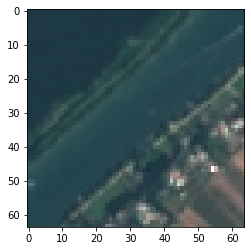

In [47]:
plt.imshow(Xval[1])
yval[1]

In [0]:
# We add a visualization on the activations
vis = callbacks.ActivationsVisualizationCallback(
        validation_data=(Xval[1:], yval[1:]),
        layers_name=["conv2d_3"],
        output_dir='./visualizations',
    )

In [0]:
net = build_network()
net.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(), metrics=['accuracy'])
net.fit(dataset.shuffle(1000).batch(32), epochs=3, callbacks=[vis])

In [0]:
# Needed for the Tensorboard
!pip install --upgrade grpcio

     |████████████████████████████████| 2.4MB 6.7MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.1 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
  Found existing installation: grpcio 1.15.0
    Uninstalling grpcio-1.15.0:
      Successfully uninstalled grpcio-1.15.0


In [0]:
%load_ext tensorboard

In [0]:
# Check the visualizations!
%tensorboard --logdir ./visualizations

### Explaining the predictions during inference

In [0]:
!pip install lime

     |████████████████████████████████| 276kB 6.6MB/s 
  Created wheel for lime: filename=lime-0.1.1.36-cp36-none-any.whl size=284191 sha256=29b4c045f6c4f542a3538d8d6c2a8ad1ca282029837b9fa5ca42ccebe854f26c
  Stored in directory: /root/.cache/pip/wheels/a9/2f/25/4b2127822af5761dab9a27be52e175105772aebbcbc484fb95
Successfully built lime


In [0]:
# Check out the documentation!
# https://github.com/marcotcr/lime

In [0]:
from lime import lime_image

In [0]:
explainer = lime_image.LimeImageExplainer()

In [0]:
explanation = explainer.explain_instance(Xval[1], net.predict, hide_color=0, num_samples=1000)

In [0]:
from skimage.segmentation import mark_boundaries

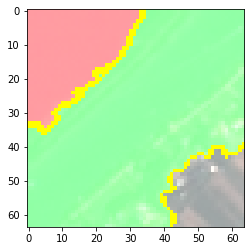

In [0]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=3, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))